In [10]:
import cv2, numpy as np,imutils
img="C:\\Users\\saha1\\OneDrive\\Desktop\\Python\\images\\img04.jpg"
#img = cv2.resize(img, (620,480) )
img = cv2.imread(img,cv2.IMREAD_COLOR)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #convert img into grayscale

In [2]:
cv2.imshow("img",gray) #display img
cv2.waitKey(0)
cv2.destroyAllWindows()

In [3]:
img_blur = cv2.GaussianBlur(gray, (3,3), 0) #applying gaussian blur
#img_blur = cv2.bilateralFilter(gray, 13, 15, 15)
cv2.imshow("img",img_blur) #display img
cv2.waitKey(0)
cv2.destroyAllWindows()

In [4]:
edged = cv2.Canny(gray, 30, 200) #Perform Edge detection
cv2.imshow("img",edged) #display img
cv2.waitKey(0)
cv2.destroyAllWindows()

In [5]:
#countour detection
contours=cv2.findContours(edged.copy(),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(contours)
contours = sorted(contours,key=cv2.contourArea, reverse = True)[:10]
screenCnt = None

In [6]:
contours1=cv2.findContours(edged.copy(),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
print(len(contours1))

2


In [7]:
for c in contours:
    
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.018 * peri, True)
 
    if len(approx) == 4:
        screenCnt = approx
        break

if screenCnt is None:
    detected = 0
    print ("No contour detected")
else:
     detected = 1

if detected == 1:
    cv2.drawContours(img, [screenCnt], -1, (0, 0, 255), 3)

mask = np.zeros(gray.shape,np.uint8)
new_image = cv2.drawContours(mask,[screenCnt],0,255,-1,)
new_image = cv2.bitwise_and(img,img,mask=mask)

cv2.imshow("img",new_image) #display img
cv2.waitKey(0)
cv2.destroyAllWindows()


In [15]:
(x, y) = np.where(mask == 255)
(topx, topy) = (np.min(x), np.min(y))
(bottomx, bottomy) = (np.max(x), np.max(y))
Cropped = gray[topx:bottomx+1, topy:bottomy+1]
cv2.imshow("img",Cropped) #display img
cv2.waitKey(0)
cv2.destroyAllWindows()

In [16]:
#Read the number plate
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'C:\\Program Files\\Tesseract-OCR\\tesseract.exe'
text = pytesseract.image_to_string(Cropped, config='--psm 10')
print("Detected license plate Number is:", text)

Detected license plate Number is: HR26DK8337|



In [17]:
plate=""
for x in text.upper():
    if (ord(x) >= ord('A') and ord(x)<=ord('Z')) or (ord(x) >=ord('0') and ord(x)<=ord('9')):
        plate+=x
print(plate)

HR26DK8337


In [31]:
import pymongo
myclient = pymongo.MongoClient("mongodb://localhost:27017/") #connecting to the mongo db server using the respective connection string
mydb = myclient["Parking-DB"]#creating a database named Parking-DB
mycol = mydb["Index"]#Creating a collection named Index in the above DB i.e. it is used for referencing the available DB for parking slots
#mydict = { "B1": "" }

#x = mycol.insert_one(mydict)
#myclient.list_database_names()

In [32]:
x=[None,None,None]#x is for creating multiple data in the Index collection
for i in range(3):
    basement='B'+str(i+1)
    mydict = { "_id": basement,"Parking_count":0 }
    x[i] = mycol.insert_one(mydict) #initially the data is in form of id as basement nos. and parking count as 0

In [33]:
bases=[None,None,None] # bases is used for creating multiple basement collections
slots=[[None for j in range(5)]for i in range(3)] # slots is used for creating multiple slot entries
for i in range(3):
    basement='B'+str(i+1) #creates collection names as B1,B2,B3 on respective iterations
    bases[i]=mydb[basement] # creates the collection
    for j in range(5):
        mydict={"_id":j+1,"Reg_No":"","Entry_time":""}
        slots[i][j]=bases[i].insert_one(mydict)#initially the data is in form of id as parking slot nos.,Reg.No as "",Entry_time as ""


In [34]:
slots

[[<pymongo.results.InsertOneResult at 0x2005c8dcf10>,

In [9]:
#mydict = { "Reg.No": "", "Entry_time": "" }

#x = mycol.insert_one(mydict)
#myclient.list_database_names()

['Index-DB', 'admin', 'config', 'local']

In [10]:
#myquery = {  "Entry_time": "" }

#mycol.delete_one(myquery)

In [26]:
#used for deleting data based on condition
myquery = {  "Parking_count": 0 }

mycol.delete_many(myquery)

In [26]:
#used to drop a collection 
mycol.drop()

In [28]:
# base idea code for changing the number of parking spaces in index collection
myquery = { "Parking_count": { "$lt": 5 } } 
mydoc = mycol.find_one(myquery)
val=mydoc["Parking_count"]
newvalues = { "$set": {"Parking_count": val+1 } }
mycol.update_one(myquery, newvalues)
mydoc

TypeError: 'NoneType' object is not subscriptable

In [29]:
#reset
myquery = { "Parking_count": { "$lte": 6 } }
newvalues = { "$set": {"Parking_count": 0 } } 
mycol.update_many(myquery, newvalues)

In [35]:
#to insert the data(complete code)
import datetime
myquery = { "Parking_count": { "$lt": 5 } } 
mydoc = mycol.find_one(myquery)
val=mydoc["Parking_count"]
newvalues = { "$set": {"Parking_count": val+1 } }
mycol.update_one(myquery, newvalues)
update_col = mydb[str(mydoc["_id"])]
myquery1 = {"Reg_No":""}
mydoc1 = update_col.find_one(myquery1)
a=datetime.datetime.now()
newvalues1 ={"$set":{"Reg_No":plate,"Entry_time":str(a)}} #replace PY01BG4545 with variable plate
update_col.update_one(myquery1,newvalues1)


In [36]:
#used for retrieving the parking info
search_string=plate #replace PY01BG4545 with variable plate
basements=['B1','B2','B3']
base_data=None
mydoc2=None
for x in basements:
    base_data=x
    col = mydb[x]
    mydoc2 = col.find_one({"Reg_No":search_string})
    if mydoc2 != None:
        break

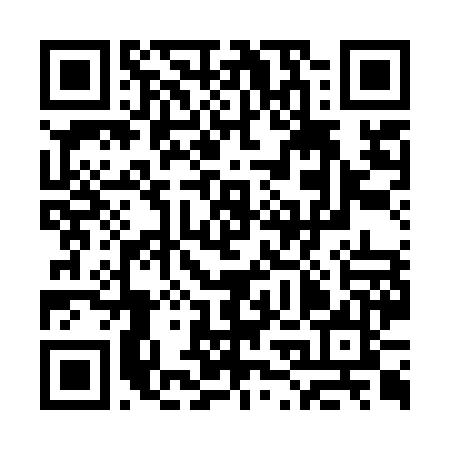

In [37]:
#qr code generation
import qrcode
text="Basement:"+str(base_data)+"\n Parking no.:"+str(mydoc2["_id"])+"\n Register no:"+str(mydoc2["Reg_No"])+"\n Entry log:"+str(mydoc2["Entry_time"])
qrcode.make(text)

In [38]:
# deletion from db

# first insert the data of that car into history db
hist_db = myclient["History_DB"]
hist_col = hist_db["History_data"]
a1 = hist_col.find_one({"_id":search_string})
b=datetime.datetime.now()
if a1==None:
    hist_col.insert_one({"_id":search_string,"Time":[]})
hist_col.update_one({"_id":search_string},{"$push":{"Time":(str(mydoc2["Entry_time"]),str(b))}})
mydb[base_data].update_one({"Reg_No":search_string},{"$set":{"Reg_No":"","Entry_time":""}})
#mydoc2["Reg_No"] = mydoc2["Entry_time"] =""
col1 = mydb["Index"]
col2 = col1.find_one({"_id":base_data})
val=col2["Parking_count"]
col1.update_one({"_id":base_data},{"$set":{"Parking_count":val-1}})